<a href="https://colab.research.google.com/github/geopayme/hubot/blob/master/DLSFH_Entropy_Comparison_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 Comparative Solar Entropy Diagnostic Notebook
This notebook allows you to upload two magnetogram images and compare their:
- Entropy maps
- 20-node DLSFH vectors
- Zone overlays
- Statistical properties
- Side-by-side interpretations

In [6]:
# 📤 Upload two solar magnetogram images
from google.colab import files
uploaded = files.upload()
image_files = list(uploaded.keys())
assert len(image_files) == 2, 'Please upload exactly 2 images for comparison.'
image1_path, image2_path = image_files
print(f'Image 1: {image1_path}')
print(f'Image 2: {image2_path}')

Saving bbzqa250328t0004_dim-860.jpg to bbzqa250328t0004_dim-860.jpg
Saving bbzqa150802t0034_dim-860.jpg to bbzqa150802t0034_dim-860.jpg
Image 1: bbzqa250328t0004_dim-860.jpg
Image 2: bbzqa150802t0034_dim-860.jpg


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def generate_entropy_map(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    h, w = img_array.shape
    cx, cy = w // 2, h // 2
    radius = min(cx, cy) - 10
    y_idx, x_idx = np.ogrid[:h, :w]
    mask = (x_idx - cx)**2 + (y_idx - cy)**2 <= radius**2
    disk_values = img_array[mask]
    scaled_field = (disk_values / 255.0) * 200 - 100
    hist, bin_edges = np.histogram(scaled_field, bins=50, density=True)
    entropy_map = np.zeros_like(img_array, dtype=float)
    entropy_map[mask] = np.interp(disk_values, bin_edges[:-1], hist)
    return entropy_map, (cx, cy, radius), img_array

In [8]:
def extract_entropy_vector(entropy_map, cx, cy, radius):
    angles = np.linspace(0, 2 * np.pi, 21)
    radii = [0.3, 0.65]
    zones = [(int(cx + r * radius * np.cos((angles[i]+angles[i+1])/2)),
              int(cy + r * radius * np.sin((angles[i]+angles[i+1])/2)))
             for r in radii for i in range(10)]
    h, w = entropy_map.shape
    kernel = 20
    vector = np.array([
        np.mean(entropy_map[max(0, y-kernel):min(h, y+kernel), max(0, x-kernel):min(w, x+kernel)])
        for x, y in zones
    ])
    return vector, zones

In [9]:
# 🔍 Generate entropy maps and vectors
entropy1, geo1, img1 = generate_entropy_map(image1_path)
entropy2, geo2, img2 = generate_entropy_map(image2_path)
vec1, zones1 = extract_entropy_vector(entropy1, *geo1)
vec2, zones2 = extract_entropy_vector(entropy2, *geo2)
print('✅ Entropy vectors extracted.')

✅ Entropy vectors extracted.


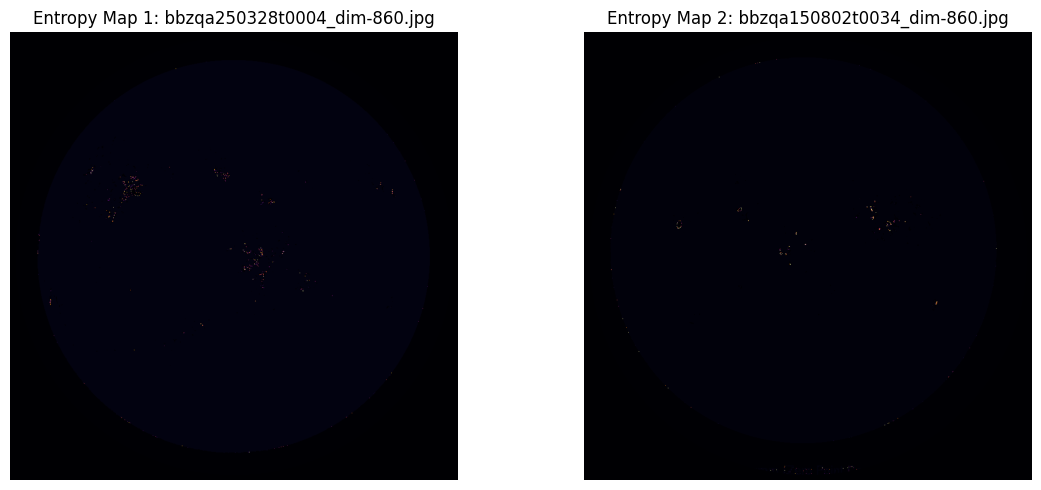

In [10]:
# 📊 Side-by-side entropy maps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(entropy1, cmap='inferno')
axs[0].set_title(f'Entropy Map 1: {image1_path}')
axs[1].imshow(entropy2, cmap='inferno')
axs[1].set_title(f'Entropy Map 2: {image2_path}')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

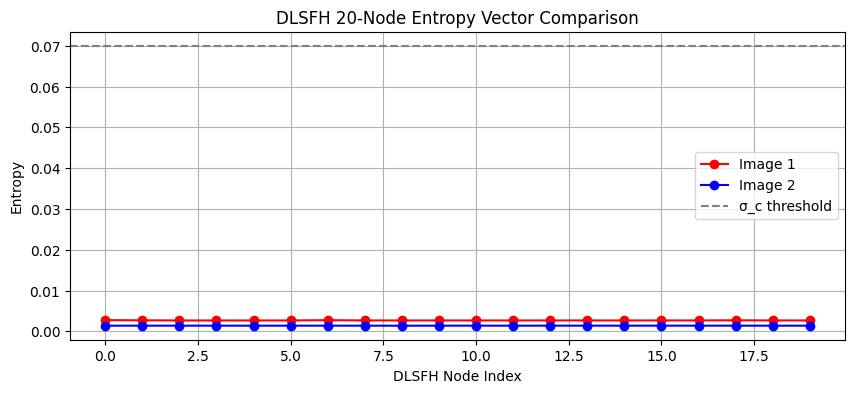

In [11]:
# 📈 Compare entropy vectors
plt.figure(figsize=(10,4))
plt.plot(vec1, 'o-r', label='Image 1')
plt.plot(vec2, 'o-b', label='Image 2')
plt.axhline(0.07, color='gray', linestyle='--', label='σ_c threshold')
plt.title('DLSFH 20-Node Entropy Vector Comparison')
plt.xlabel('DLSFH Node Index')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 🧠 Numerical diagnostics
def describe_vector(vec, label):
    print(f'-- {label} --')
    print(f'Mean: {np.mean(vec):.4f} | Std: {np.std(vec):.4f} | Max: {np.max(vec):.4f}')
    print(f'Collapsed Nodes (≥ 0.07): {np.sum(vec >= 0.07)}/20')
    print()

describe_vector(vec1, image1_path)
describe_vector(vec2, image2_path)

-- bbzqa250328t0004_dim-860.jpg --
Mean: 0.0027 | Std: 0.0000 | Max: 0.0027
Collapsed Nodes (≥ 0.07): 0/20

-- bbzqa150802t0034_dim-860.jpg --
Mean: 0.0014 | Std: 0.0000 | Max: 0.0014
Collapsed Nodes (≥ 0.07): 0/20

